In [53]:

!pip install torch torchvision

In [1]:
!unzip '/content/Welding Defect Detection.v2i.tensorflow.zip' -d '/content/dataset'

Archive:  /content/Welding Defect Detection.v2i.tensorflow.zip
 extracting: /content/dataset/README.dataset.txt  
 extracting: /content/dataset/README.roboflow.txt  
   creating: /content/dataset/test/
 extracting: /content/dataset/test/SampleV1_1_mp4-1_jpg.rf.3f50c974a91c4e6348dd49491f06def8.jpg  
 extracting: /content/dataset/test/SampleV1_1_mp4-42_jpg.rf.6e68d9186e630ffb996233ad2a593f51.jpg  
 extracting: /content/dataset/test/SampleV1_2_mp4-14_jpg.rf.4dba7e8bd84314a155dd85df33b5f4d9.jpg  
 extracting: /content/dataset/test/SampleV2_1_mp4-0_jpg.rf.32dc225d9b5d11d01260f75c918a9961.jpg  
 extracting: /content/dataset/test/SampleV2_1_mp4-59_jpg.rf.b500f4a89177615c16be765f9f15b910.jpg  
 extracting: /content/dataset/test/SampleV2_1_mp4-60_jpg.rf.40f4a4094130e65b1a801b49fefc5d01.jpg  
 extracting: /content/dataset/test/SampleV2_1_mp4-90_jpg.rf.19ad4979865d6aba1cfaaa23f1dfb1f9.jpg  
 extracting: /content/dataset/test/SampleV2_1_mp4-97_jpg.rf.1cbd06413c3d08495ffce915e0d8bd94.jpg  
 extract

# important library:

In [2]:
# Standard library imports
import os  # For handling file paths
import random  # For generating random numbers
from collections import Counter  # For counting hashable objects

# Third-party imports
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
from PIL import Image, ImageDraw  # For image handling and drawing
import matplotlib.pyplot as plt  # For plotting
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets

# PyTorch imports
import torch  # For tensor operations and neural networks
import torchvision  # For computer vision tasks

# Torchvision imports
from torchvision import transforms as T  # For data transformations
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  # For Faster R-CNN model


# load train data:

In [3]:
train = pd.read_csv("/content/dataset/train/_annotations.csv")
train.head()

filename  width  height  \
0  SampleV3_2_mp4-23_jpg.rf.d1cfdcce29497d5b67d27...    640     640   
1  SampleV3_2_mp4-23_jpg.rf.d1cfdcce29497d5b67d27...    640     640   
2  SampleV3_2_mp4-23_jpg.rf.d1cfdcce29497d5b67d27...    640     640   
3  SampleV3_2_mp4-23_jpg.rf.d1cfdcce29497d5b67d27...    640     640   
4  SampleV3_2_mp4-23_jpg.rf.d1cfdcce29497d5b67d27...    640     640   

          class  xmin  ymin  xmax  ymax  
0     Workpiece     0   188   540   317  
1  Welding Line     0   236   526   266  
2     Workpiece     0   438   534   582  
3  Welding Line     0   499   512   538  
4        Defect   312   510   396   542

- Drop unneeded column:

In [4]:
train.drop(['width','height','class'],axis=1,inplace=True)

In [5]:
train.head()

filename  xmin  ymin  xmax  ymax
0  SampleV3_2_mp4-23_jpg.rf.d1cfdcce29497d5b67d27...     0   188   540   317
1  SampleV3_2_mp4-23_jpg.rf.d1cfdcce29497d5b67d27...     0   236   526   266
2  SampleV3_2_mp4-23_jpg.rf.d1cfdcce29497d5b67d27...     0   438   534   582
3  SampleV3_2_mp4-23_jpg.rf.d1cfdcce29497d5b67d27...     0   499   512   538
4  SampleV3_2_mp4-23_jpg.rf.d1cfdcce29497d5b67d27...   312   510   396   542

In [6]:
train['filename'][0]

'SampleV3_2_mp4-23_jpg.rf.d1cfdcce29497d5b67d2763cfd31506f.jpg'

- Take the unique ids of the images:

In [7]:
val_df = pd.read_csv('/content/dataset/valid/_annotations.csv')
val_df.drop(['width','height','class'],axis=1,inplace=True)
val_df.head()

filename  xmin  ymin  xmax  ymax
0  SampleV1_1_mp4-18_jpg.rf.cddd27bcf2b930148b836...   217     0   550   344
1  SampleV1_1_mp4-18_jpg.rf.cddd27bcf2b930148b836...   220   449   529   640
2  SampleV1_1_mp4-18_jpg.rf.cddd27bcf2b930148b836...   325     0   394   327
3  SampleV1_1_mp4-18_jpg.rf.cddd27bcf2b930148b836...   316   458   377   640
4  SampleV1_1_mp4-18_jpg.rf.cddd27bcf2b930148b836...   312     0   406   236

In [8]:
unique_imgs1=train.filename.unique()
unique_imgs2=val_df.filename.unique()
unique_imgs1

array(['SampleV3_2_mp4-23_jpg.rf.d1cfdcce29497d5b67d2763cfd31506f.jpg',
       'SampleV3_1_mp4-14_jpg.rf.d32a4d7ecdc2e08d17a4a6c6218d6c3c.jpg',
       'SampleV2_1_mp4-32_jpg.rf.d3562e09a5d82c9f5552b831a0988ffb.jpg',
       'SampleV2_1_mp4-17_jpg.rf.d2b579c298b89c7847399ee6653a7565.jpg',
       'SampleV2_2_mp4-40_jpg.rf.d6e8b644033447ce21714b07b4891cc5.jpg',
       'SampleV2_2_mp4-4_jpg.rf.d4e2d2278bd673e1d9f515591ad90e9f.jpg',
       'SampleV2_2_mp4-30_jpg.rf.d7b64c1e21456a10cc9855ba5685815d.jpg',
       'SampleV1_1_mp4-40_jpg.rf.d5d9351523e0baa998e6d3c94b408ebd.jpg',
       'SampleV3_2_mp4-6_jpg.rf.d1ea5fc9a4d67fff3e88507184f17b6a.jpg',
       'SampleV3_2_mp4-13_jpg.rf.d4e6d6e395bab8be92a029407aa865c1.jpg',
       'SampleV2_1_mp4-10_jpg.rf.d1e56bfef0409aea474170ec343b3208.jpg',
       'SampleV3_2_mp4-29_jpg.rf.d5409361480470a7e4819064b36d9ff3.jpg',
       'SampleV2_1_mp4-100_jpg.rf.d3e1952bee28fff0142e47b56e662938.jpg',
       'SampleV1_1_mp4-44_jpg.rf.d47f451f71af7fc0f8525c9b4ea306df

In [9]:
unique_imgs1.shape[0], unique_imgs2.shape[0]

(916, 81)

- Make custom class for preparing the data:

In [10]:
# Define a custom dataset class inheriting from torch.utils.data.Dataset
class custDat1(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        """
        Initialize the dataset with a DataFrame, a list of unique image names, and indices.

        Args:
            df (pd.DataFrame): DataFrame containing image IDs and bounding box information.
            unique_imgs (list): List of unique image names.
            indices (list): List of indices to be used for accessing the dataset.
        """
        self.df = df  # DataFrame containing image and bounding box data
        self.unique_imgs = unique_imgs  # List of unique image names
        self.indices = indices  # Indices for accessing the images in the dataset

    def __len__(self):
        """
        Return the length of the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.indices)  # Length of the dataset based on the indices

    def __getitem__(self, idx):
        """
        Get an item from the dataset at the specified index.

        Args:
            idx (int): Index of the item to be fetched.

        Returns:
            tuple: Tuple containing the image tensor and the target dictionary.
        """
        # Get the image name using the index
        image_name = self.unique_imgs[self.indices[idx]]

        # Get the bounding boxes for the image
        boxes = self.df[self.df['filename'] == image_name].values[:, 1:].astype("float")

        # Open the image and convert it to RGB format
        img = Image.open("/content/dataset/train/" + image_name).convert('RGB')

        # Create labels tensor with value 1 for each bounding box
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)

        # Create the target dictionary containing boxes and labels
        target = {}
        target["boxes"] = torch.tensor(boxes)  # Bounding boxes as a tensor
        target["label"] = labels  # Labels as a tensor

        # Return the image converted to a tensor and the target dictionary
        return T.ToTensor()(img), target


# for val dataset

# Define a custom dataset class inheriting from torch.utils.data.Dataset
class custDat2(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        """
        Initialize the dataset with a DataFrame, a list of unique image names, and indices.

        Args:
            df (pd.DataFrame): DataFrame containing image IDs and bounding box information.
            unique_imgs (list): List of unique image names.
            indices (list): List of indices to be used for accessing the dataset.
        """
        self.df = df  # DataFrame containing image and bounding box data
        self.unique_imgs = unique_imgs  # List of unique image names
        self.indices = indices  # Indices for accessing the images in the dataset

    def __len__(self):
        """
        Return the length of the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.indices)  # Length of the dataset based on the indices

    def __getitem__(self, idx):
        """
        Get an item from the dataset at the specified index.

        Args:
            idx (int): Index of the item to be fetched.

        Returns:
            tuple: Tuple containing the image tensor and the target dictionary.
        """
        # Get the image name using the index
        image_name = self.unique_imgs[self.indices[idx]]

        # Get the bounding boxes for the image
        boxes = self.df[self.df['filename'] == image_name].values[:, 1:].astype("float")

        # Open the image and convert it to RGB format
        img = Image.open("/content/dataset/valid/" + image_name).convert('RGB')

        # Create labels tensor with value 1 for each bounding box
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)

        # Create the target dictionary containing boxes and labels
        target = {}
        target["boxes"] = torch.tensor(boxes)  # Bounding boxes as a tensor
        target["label"] = labels  # Labels as a tensor

        # Return the image converted to a tensor and the target dictionary
        return T.ToTensor()(img), target


In [11]:
def custom_collate(data):
    return data

# Call the data loader to prepare it to the model:

In [12]:
train_dl = torch.utils.data.DataLoader(custDat1(train,unique_imgs1,range(unique_imgs1.shape[0])),
                                       batch_size=16,
                                       shuffle=True,
                                       collate_fn=custom_collate,
                                       pin_memory=True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(custDat2(val_df,unique_imgs2,range(unique_imgs2.shape[0])),
                                     batch_size=8,
                                     shuffle=True,
                                     collate_fn=custom_collate,
                                     pin_memory=True if torch.cuda.is_available() else False)

# Modeling:

In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 165MB/s]


In [14]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [15]:
num_classes=2

In [16]:
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor =  FastRCNNPredictor(in_features,num_classes)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [18]:
device

device(type='cuda')

In [19]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.005)
num_epochs=300

_ train the model with 5 epochs and prin the loss:

In [20]:
# Move the model to the specified device (CPU or GPU)
model.to(device)

# Loop over the number of epochs
for epoch in range(num_epochs):
    epoch_loss = 0  # Initialize the loss for the current epoch

    # Loop over the data in the training DataLoader
    for data in train_dl:
        imgs = []  # List to store the images
        targets = []  # List to store the target dictionaries

        # Loop over each data sample in the batch
        for d in data:
            # Append the image tensor to the imgs list and move it to the device
            imgs.append(d[0].to(device))

            # Create a target dictionary for the current sample
            targ = {}
            # Move the bounding boxes tensor to the device
            targ['boxes'] = d[1]['boxes'].to(device)
            # Move the labels tensor to the device
            targ['labels'] = d[1]['label'].to(device)

            # Append the target dictionary to the targets list
            targets.append(targ)

        # Perform a forward pass through the model and get the loss dictionary
        loss_dict = model(imgs, targets)

        # Sum all the losses in the loss dictionary to get the total loss
        loss = sum(v for v in loss_dict.values())

        # Add the loss for the current batch to the epoch loss, converting it to a numpy value
        epoch_loss += loss.cpu().detach().numpy()

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Update the model parameters
        optimizer.step()

    # Print the total loss for the current epoch
    print(epoch_loss)

58.767888860456836
36.61447109624997
33.124643016717044
30.957579495008343
29.629875664254907
28.29351466875104
27.221877572846637
25.669814396699707
24.59715762951403
23.604073692208946


- Evaluate the model

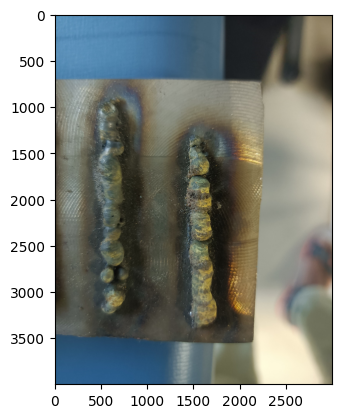

In [45]:
img= '/content/WhatsApp Image 2024-06-02 at 11.03.20 AM.jpeg'
import matplotlib.pyplot as plt
img = Image.open(img).convert('RGB')
plt.imshow(img)

- prediction detection:

In [46]:
# Convert PIL Image to PyTorch Tensor
img_tensor = torchvision.transforms.ToTensor()(img)

# Now you can use permute on the tensor
im = (img_tensor.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')
im

array([[[ 82, 140, 186],
        [ 85, 143, 189],
        [ 87, 145, 191],
        ...,
        [120, 120,  96],
        [120, 120,  96],
        [120, 120,  96]],

       [[ 83, 141, 187],
        [ 86, 144, 190],
        [ 88, 146, 192],
        ...,
        [120, 120,  96],
        [120, 120,  96],
        [120, 120,  96]],

       [[ 85, 144, 188],
        [ 88, 147, 191],
        [ 90, 149, 193],
        ...,
        [121, 119,  94],
        [121, 119,  94],
        [121, 119,  94]],

       ...,

       [[ 44,  95, 140],
        [ 43,  94, 139],
        [ 43,  94, 139],
        ...,
        [118, 116,  91],
        [118, 116,  91],
        [118, 116,  91]],

       [[ 42,  93, 138],
        [ 43,  94, 139],
        [ 43,  94, 139],
        ...,
        [118, 116,  91],
        [118, 116,  91],
        [117, 115,  90]],

       [[ 42,  93, 138],
        [ 42,  93, 138],
        [ 43,  94, 139],
        ...,
        [118, 116,  91],
        [118, 116,  91],
        [117, 115,  90]]

In [47]:
model.eval()

# Perform inference
with torch.no_grad():
    predictions = model([img_tensor.to(device)])

In [48]:
predictions

[{'boxes': tensor([[  35.1138,  749.9800, 2299.6848, 3564.6035],
          [1364.7540, 1385.5383, 1709.5911, 2594.8325],
          [1431.4291, 1847.6687, 1720.4166, 2443.1707],
          [ 328.4504,  784.2535, 1047.3175, 3318.5935],
          [ 408.0280, 1047.9465,  749.7199, 2758.7900],
          [1295.3101, 1227.9026, 1724.4310, 1604.9796],
          [1194.2916,  865.2446, 2131.8047, 3534.6089],
          [ 408.7685,  947.2368,  741.4489, 1545.0800],
          [1343.1637, 1668.0684, 1780.3119, 2362.1262],
          [ 445.6911,  765.5078,  876.0896, 1068.0092],
          [1405.7308, 1218.8486, 1858.9763, 3494.1086],
          [1452.7977, 2373.8931, 1739.2520, 3388.5176],
          [1322.6672, 1290.2211, 1671.6322, 1772.1272],
          [1367.3478, 1973.4506, 1829.2539, 2278.3933],
          [ 420.3944, 2514.8953,  812.0741, 3226.3713],
          [ 401.3611,  812.6790,  936.3535, 1660.0543],
          [ 398.1387, 1693.0095,  758.1322, 2321.5493],
          [ 428.5285, 2701.3423,  813.1

In [49]:
out_bbox=predictions[0]['boxes']
out_scores=predictions[0]['scores']

out_bbox.shape

torch.Size([56, 4])

In [50]:
keep = torchvision.ops.nms(out_bbox,out_scores,0.100)
keep

tensor([ 0,  1,  4,  9, 11, 17, 21, 22, 28, 31, 38, 39, 50, 53],
       device='cuda:0')

In [51]:
out_bbox = out_bbox[keep]
out_bbox[0]

tensor([  35.1138,  749.9800, 2299.6848, 3564.6035], device='cuda:0')

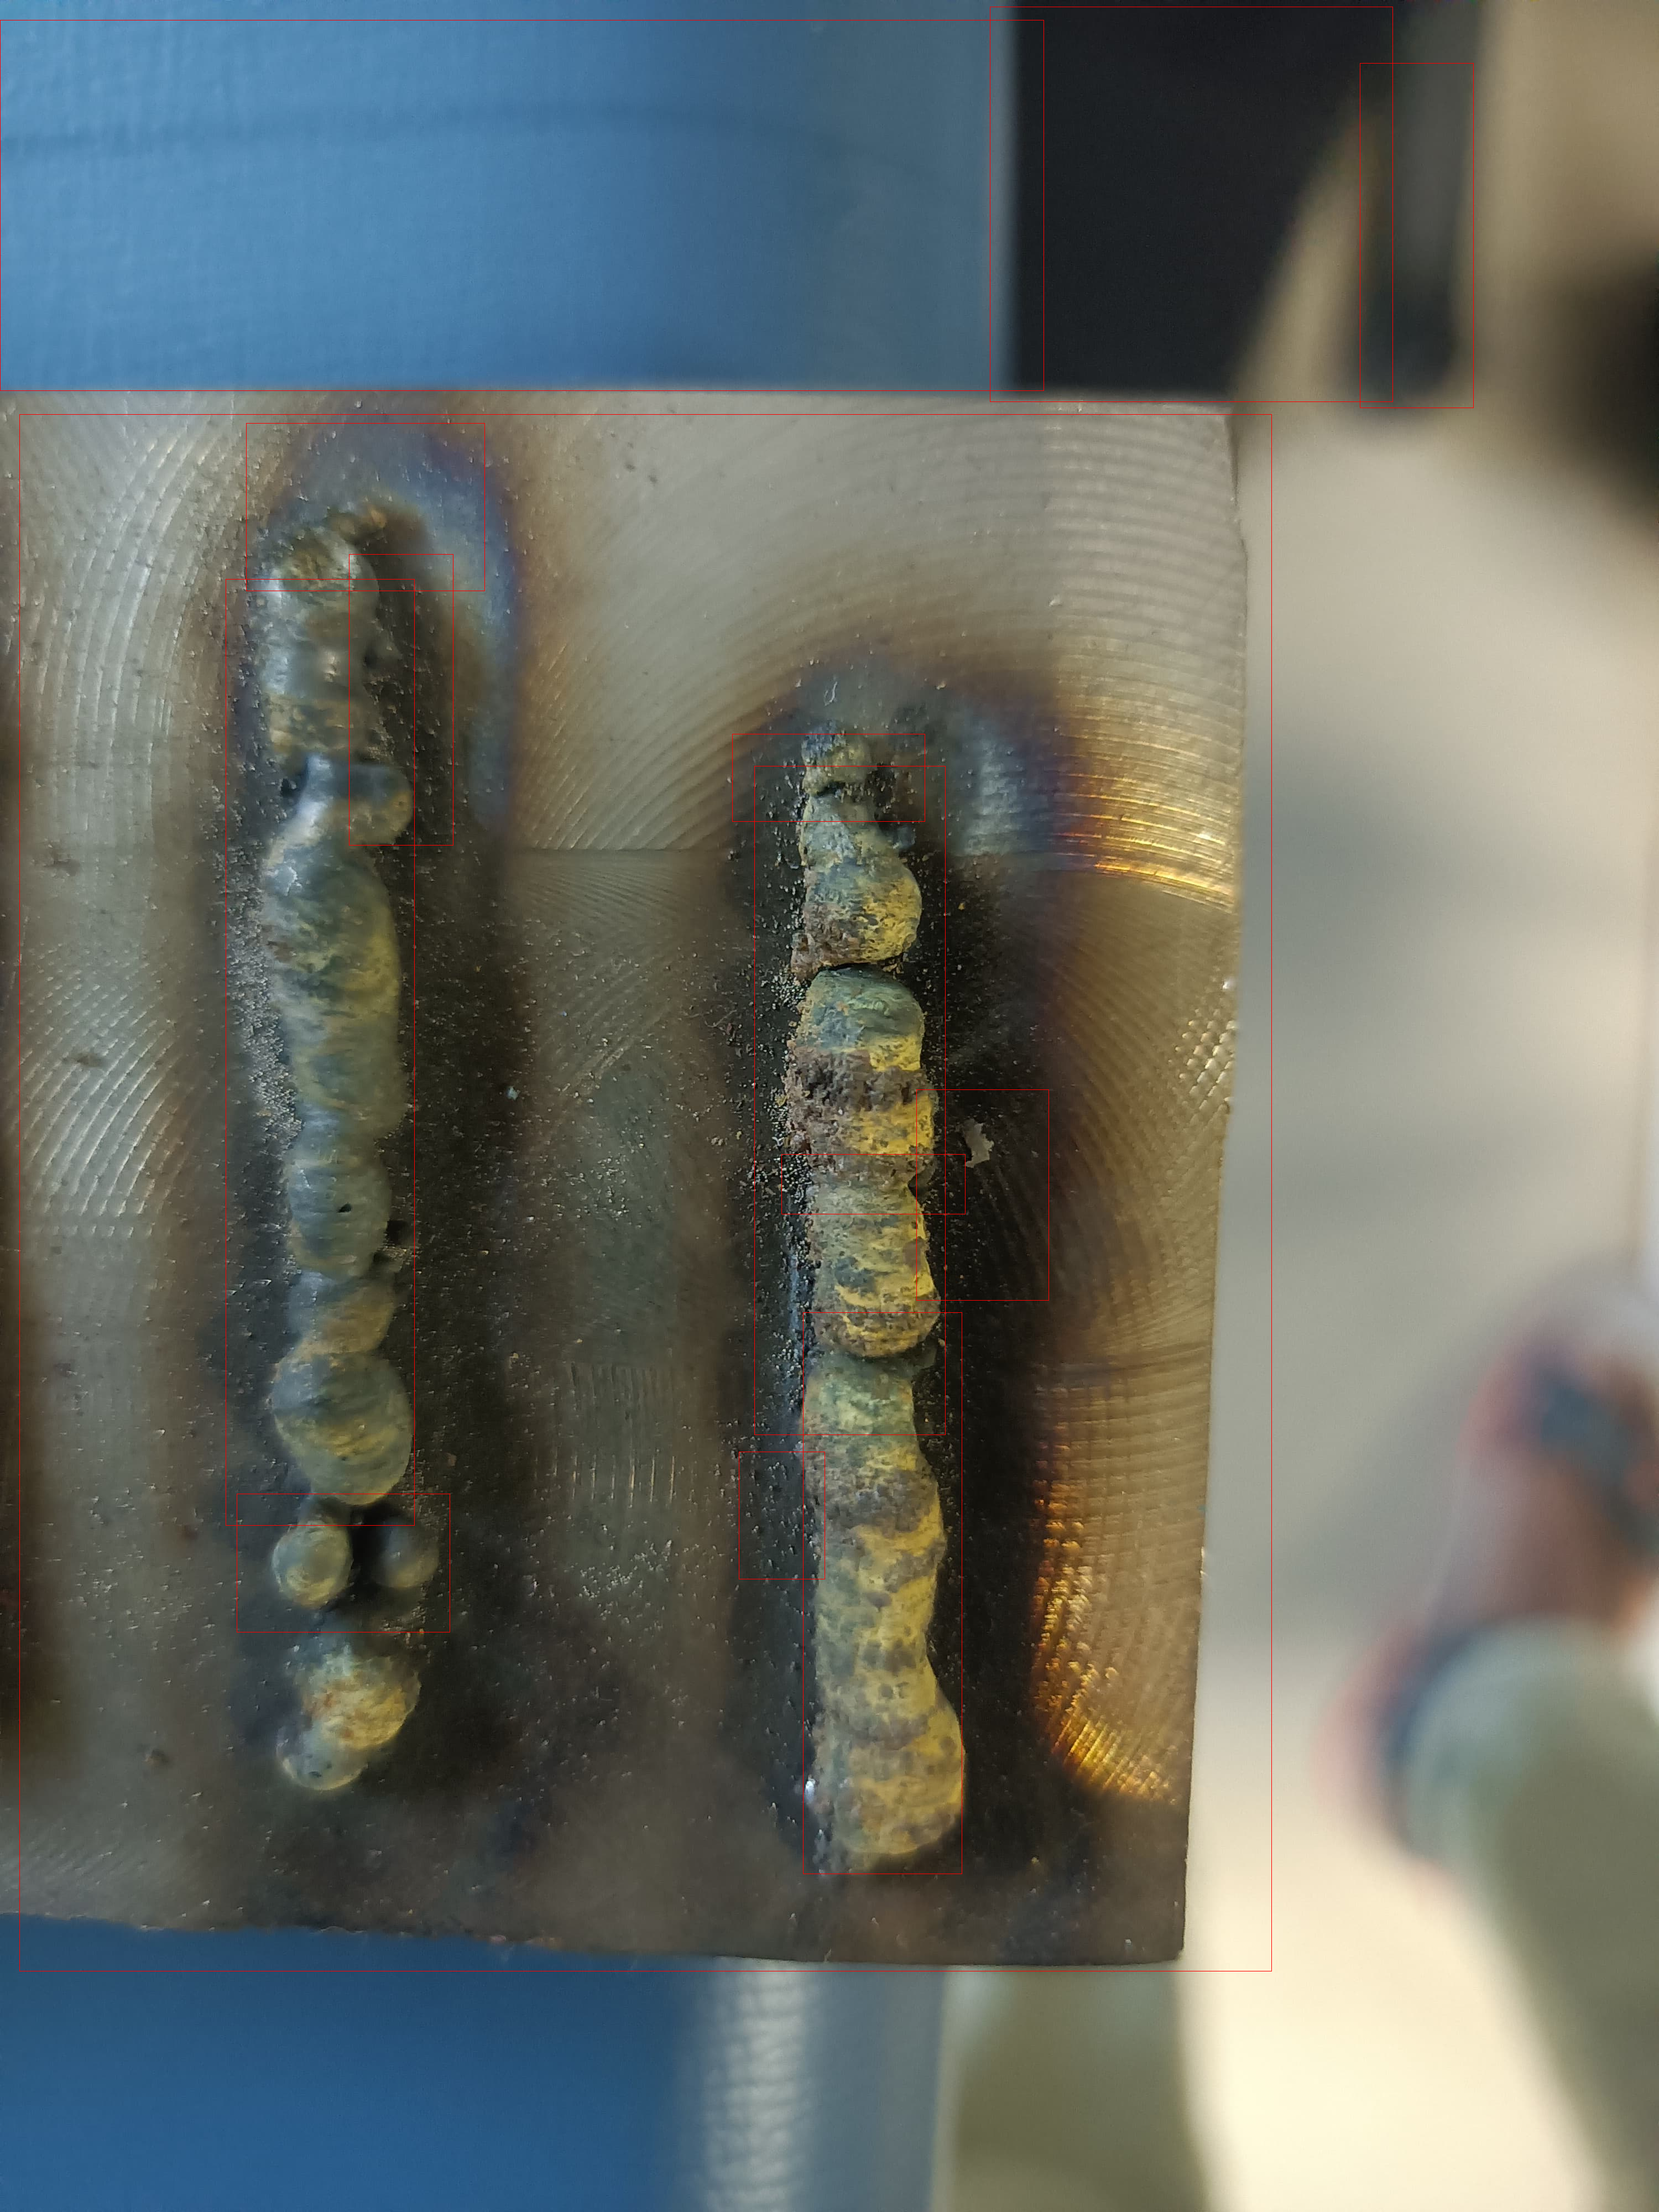

In [52]:
im = Image.fromarray(im)
draw = ImageDraw.Draw(im)
for box in out_bbox :
    draw.rectangle(tuple(box.tolist()), fill=None, outline='red')
im